In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import os
import cv2

image_dir = "/content/drive/MyDrive/Colab Notebooks/SEPTIMO TRIMESTRE/DATASETS 1 DE FEBRERO 2026"
image_files = os.listdir(image_dir)

print(f"Total de imágenes encontradas: {len(image_files)}")

Total de imágenes encontradas: 1887


Paso 1 — Identificar cuántos archivos JPG y XML hay realmente
Aunque el conteo total dio 1887, aquí vamos a separar por extensión para confirmar cuántas imágenes (.jpg/.jpeg) y cuántas anotaciones (.xml) hay, y detectar archivos extra (por ejemplo, .DS_Store, carpetas, etc.). Esto responde a la parte de “valores faltantes” y consistencia del dataset.

In [34]:
import os

data_dir = "/content/drive/MyDrive/Colab Notebooks/SEPTIMO TRIMESTRE/DATASETS 1 DE FEBRERO 2026"
all_items = os.listdir(data_dir)

jpg_files = sorted([f for f in all_items if f.lower().endswith((".jpg", ".jpeg"))])
xml_files = sorted([f for f in all_items if f.lower().endswith(".xml")])
others = sorted([f for f in all_items if not f.lower().endswith((".jpg", ".jpeg", ".xml"))])

print("Total en carpeta:", len(all_items))
print("JPG/JPEG:", len(jpg_files))
print("XML:", len(xml_files))
print("Otros:", len(others))
if len(others) > 0:
    print("Ejemplos de 'otros':", others[:10])


Total en carpeta: 1887
JPG/JPEG: 947
XML: 940
Otros: 0


Paso 2 — Identificación de valores faltantes en pares imagen–anotación

En un conjunto de datos de visión por computadora, los valores faltantes no se presentan como valores nulos (NaN), sino como inconsistencias entre los archivos de imagen y sus anotaciones.
En este paso se identifican:

Imágenes que no cuentan con un archivo XML asociado

Archivos XML que no tienen una imagen correspondiente

Este análisis permite evaluar la consistencia del dataset y definir estrategias de preprocesamiento, como la eliminación o corrección de muestras incompletas.

In [35]:
# Obtener los nombres base (sin extensión)
jpg_bases = set([os.path.splitext(f)[0] for f in jpg_files])
xml_bases = set([os.path.splitext(f)[0] for f in xml_files])

# Detectar valores faltantes
missing_xml = sorted(list(jpg_bases - xml_bases))   # imágenes sin XML
missing_jpg = sorted(list(xml_bases - jpg_bases))   # XML sin imagen

print("Imágenes SIN XML:", len(missing_xml))
print("XML SIN imagen:", len(missing_jpg))

if len(missing_xml) > 0:
    print("Ejemplos de imágenes sin XML:", missing_xml[:5])

if len(missing_jpg) > 0:
    print("Ejemplos de XML sin imagen:", missing_jpg[:5])

Imágenes SIN XML: 7
XML SIN imagen: 0
Ejemplos de imágenes sin XML: ['11ac5a663580287e_1763591839985_683d9d18', '14e9c250a8cb6456_1763586024615_4faf0660', '27efe612666ca096_1763586021338_5acfc32b', '4b5a750d877ba345_1763593043239_77473217', '544fc8f8633ffac1_1763586037411_1db2f8ca']


# Paso 3 - Construcción del conjunto de datos limpio
# Para realizar el análisis exploratorio de manera consistente, se construye un subconjunto del dataset
# que contiene únicamente los pares válidos donde existe tanto la imagen como su archivo de anotación.
# Este conjunto será utilizado en todos los análisis posteriores.


In [36]:
# Pares válidos imagen + XML
valid_bases = sorted(list(jpg_bases.intersection(xml_bases)))

print("Total de pares válidos (imagen + XML):", len(valid_bases))

print("Ejemplo de un par válido:")
print("Imagen:", valid_bases[0] + ".jpg (o .jpeg)")
print("XML   :", valid_bases[0] + ".xml")


Total de pares válidos (imagen + XML): 940
Ejemplo de un par válido:
Imagen: 00c5333830a93beb_1763587888711_4790779b.jpg (o .jpeg)
XML   : 00c5333830a93beb_1763587888711_4790779b.xml


Paso 4 — Estadísticas descriptivas de las dimensiones de las imágenes

En este paso se calculan estadísticas resumidas (mínimo, máximo, promedio y desviación estándar) de las dimensiones de las imágenes (alto y ancho en píxeles).
Este análisis responde a la pregunta sobre estadísticas resumidas del conjunto de datos y permite identificar posibles valores atípicos o la necesidad de normalizar las imágenes.

In [37]:
import cv2
import numpy as np

heights = []
widths = []
bad_images = []

for base in valid_bases:
    img_path = os.path.join(data_dir, base + ".jpg")
    if not os.path.exists(img_path):
        img_path = os.path.join(data_dir, base + ".jpeg")

    img = cv2.imread(img_path)
    if img is None:
        bad_images.append(base)
        continue

    h, w = img.shape[:2]
    heights.append(h)
    widths.append(w)

heights = np.array(heights)
widths = np.array(widths)

print("Imágenes leídas correctamente:", len(heights))
print("Imágenes con error:", len(bad_images))

print("\n--- Estadísticas de ALTURA (px) ---")
print("Mín:", heights.min())
print("Máx:", heights.max())
print("Media:", heights.mean())
print("Desv. estándar:", heights.std())

print("\n--- Estadísticas de ANCHO (px) ---")
print("Mín:", widths.min())
print("Máx:", widths.max())
print("Media:", widths.mean())
print("Desv. estándar:", widths.std())


Imágenes leídas correctamente: 940
Imágenes con error: 0

--- Estadísticas de ALTURA (px) ---
Mín: 540
Máx: 540
Media: 540.0
Desv. estándar: 0.0

--- Estadísticas de ANCHO (px) ---
Mín: 720
Máx: 720
Media: 720.0
Desv. estándar: 0.0


Paso 5 — Visualización de distribuciones (análisis univariado y bivariado)

Se utilizan histogramas para analizar la distribución individual de las dimensiones (análisis univariado) y una gráfica de dispersión para analizar la relación entre ancho y alto (análisis bivariado).
Esto permite identificar distribuciones sesgadas y posibles valores atípicos.

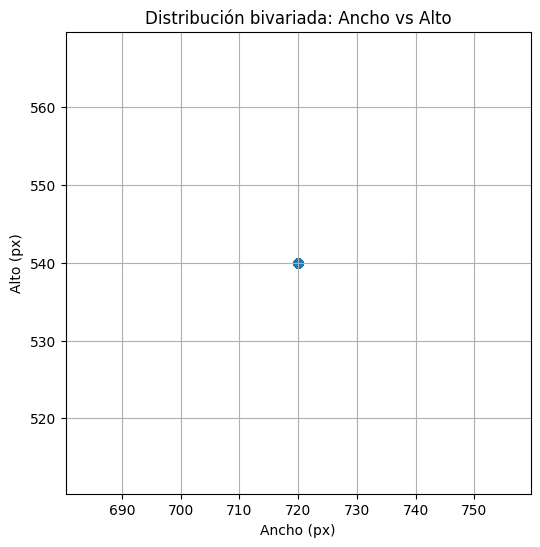

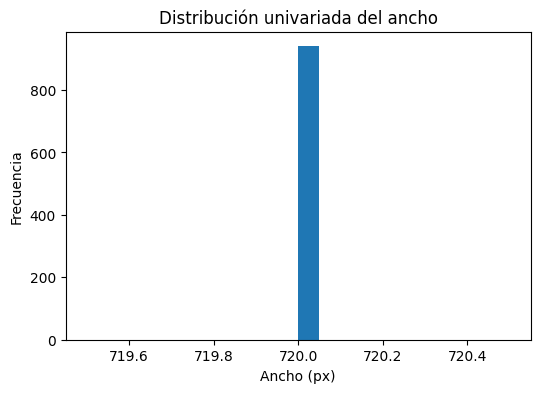

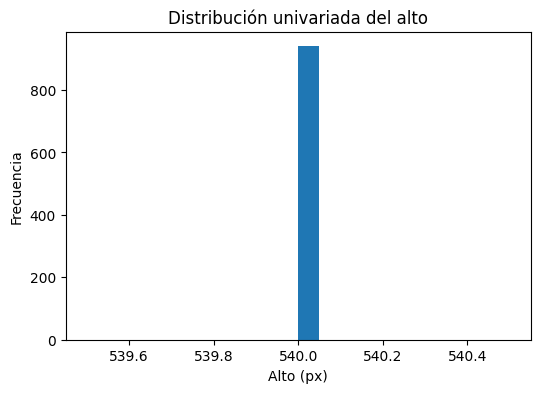

In [38]:
import matplotlib.pyplot as plt

# Análisis bivariado
plt.figure(figsize=(6,6))
plt.scatter(widths, heights)
plt.xlabel("Ancho (px)")
plt.ylabel("Alto (px)")
plt.title("Distribución bivariada: Ancho vs Alto")
plt.grid(True)
plt.show()

# Análisis univariado - ancho
plt.figure(figsize=(6,4))
plt.hist(widths, bins=20)
plt.xlabel("Ancho (px)")
plt.ylabel("Frecuencia")
plt.title("Distribución univariada del ancho")
plt.show()

# Análisis univariado - alto
plt.figure(figsize=(6,4))
plt.hist(heights, bins=20)
plt.xlabel("Alto (px)")
plt.ylabel("Frecuencia")
plt.title("Distribución univariada del alto")
plt.show()


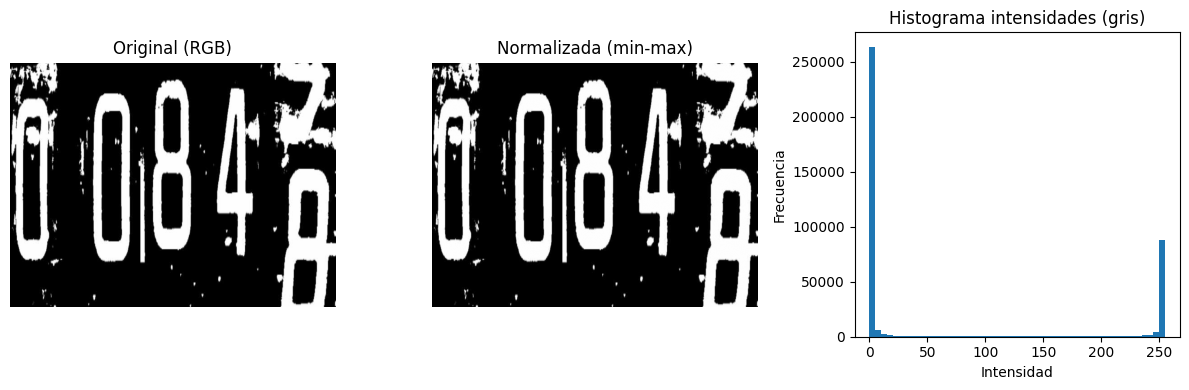

In [39]:

# Se comparan: imagen original vs imagen normalizada (min-max) y su histograma de intensidades.

import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Elegir una imagen aleatoria del dataset limpio
sample_base = random.choice(valid_bases)
# Puede ser .jpg o .jpeg, detectamos cuál existe
jpg_path = os.path.join(data_dir, sample_base + ".jpg")
jpeg_path = os.path.join(data_dir, sample_base + ".jpeg")
img_path = jpg_path if os.path.exists(jpg_path) else jpeg_path

img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Convertir a escala de grises para analizar intensidades
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Normalización min-max a [0,1]
img_norm = (img_gray - img_gray.min()) / (img_gray.max() - img_gray.min() + 1e-9)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.title("Original (RGB)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_norm, cmap="gray")
plt.title("Normalizada (min-max)")
plt.axis("off")

plt.subplot(1,3,3)
plt.hist(img_gray.ravel(), bins=50)
plt.title("Histograma intensidades (gris)")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


Paso 6 — Análisis de valores faltantes y estructura de las anotaciones XML

En este paso se analizan los archivos XML asociados a cada imagen para identificar:

Archivos XML sin objetos anotados

La cantidad de objetos por imagen

Posibles valores atípicos en el número de objetos

Este análisis permite evaluar la calidad de las anotaciones y detectar posibles inconsistencias que deban tratarse durante el preprocesamiento.

In [40]:
import xml.etree.ElementTree as ET

object_counts = []
empty_xml = []
xml_errors = []

for base in valid_bases:
    xml_path = os.path.join(data_dir, base + ".xml")
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        objects = root.findall("object")
        object_counts.append(len(objects))
        if len(objects) == 0:
            empty_xml.append(base)
    except:
        xml_errors.append(base)

object_counts = np.array(object_counts)

print("Total XML analizados:", len(object_counts))
print("XML sin objetos:", len(empty_xml))
print("XML con error de lectura:", len(xml_errors))
print("Promedio de objetos por imagen:", object_counts.mean())
print("Mín objetos por imagen:", object_counts.min())
print("Máx objetos por imagen:", object_counts.max())


Total XML analizados: 940
XML sin objetos: 0
XML con error de lectura: 0
Promedio de objetos por imagen: 5.069148936170213
Mín objetos por imagen: 1
Máx objetos por imagen: 6


Q1: 5.00 | Q3: 5.00 | IQR: 0.00
Límite inferior: 5.00 | Límite superior: 5.00
Número de outliers (IQR): 131


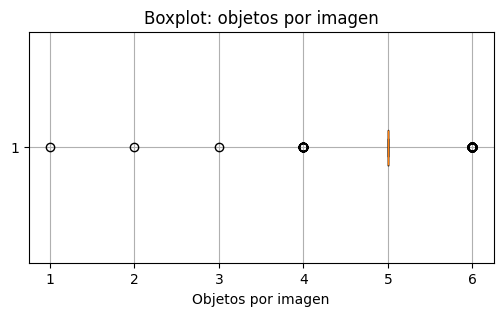

In [41]:
# Detección de valores atípicos (IQR) en número de objetos por imagen + boxplot

import numpy as np
import matplotlib.pyplot as plt

q1 = np.percentile(object_counts, 25)
q3 = np.percentile(object_counts, 75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = object_counts[(object_counts < lower) | (object_counts > upper)]

print(f"Q1: {q1:.2f} | Q3: {q3:.2f} | IQR: {iqr:.2f}")
print(f"Límite inferior: {lower:.2f} | Límite superior: {upper:.2f}")
print("Número de outliers (IQR):", len(outliers))

plt.figure(figsize=(6,3))
plt.boxplot(object_counts, vert=False)
plt.title("Boxplot: objetos por imagen")
plt.xlabel("Objetos por imagen")
plt.grid(True)
plt.show()


Distribución del número de objetos por imagen

A continuación se visualiza la distribución del número de objetos anotados por imagen para identificar posibles valores atípicos o desbalances.

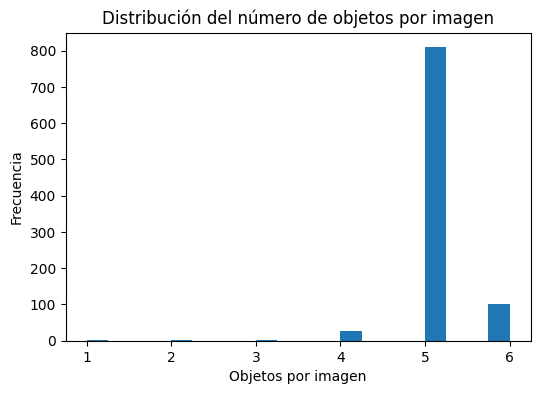

In [42]:
plt.figure(figsize=(6,4))
plt.hist(object_counts, bins=20)
plt.xlabel("Objetos por imagen")
plt.ylabel("Frecuencia")
plt.title("Distribución del número de objetos por imagen")
plt.show()


Paso 8 — Análisis de la cardinalidad de las variables categóricas

En este paso se identifican las clases presentes en las anotaciones XML y se analiza su frecuencia. La cardinalidad de las clases permite evaluar la complejidad del problema y detectar posibles desequilibrios en la variable objetivo.

In [43]:
from collections import Counter

labels = []

for base in valid_bases:
    xml_path = os.path.join(data_dir, base + ".xml")
    root = ET.parse(xml_path).getroot()
    for obj in root.findall("object"):
        name = obj.find("name").text
        labels.append(name)

label_counts = Counter(labels)

print("Número total de objetos:", len(labels))
print("Número de clases distintas:", len(label_counts))
print("Clases y frecuencias:")
for k, v in label_counts.items():
    print(f"{k}: {v}")


Número total de objetos: 4765
Número de clases distintas: 10
Clases y frecuencias:
0: 2177
7: 120
8: 1182
9: 69
4: 653
5: 241
1: 112
2: 110
3: 59
6: 42


Paso 9 - Distribución de clases (análisis univariado de la variable objetivo)

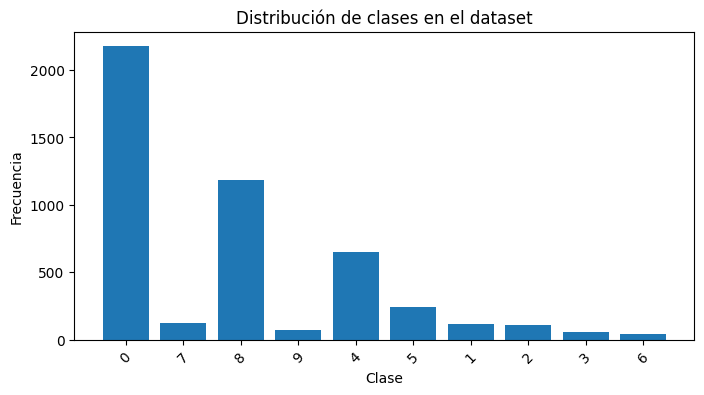

In [44]:
plt.figure(figsize=(8,4))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(rotation=45)
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases en el dataset")
plt.show()


Total bounding boxes: 4765
Área - min/mean/max: 9858 39107.14354669465 84078


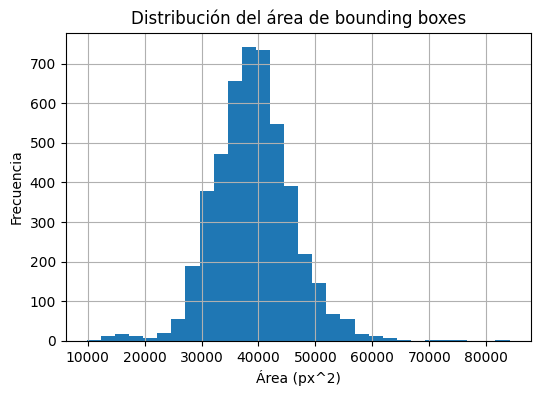

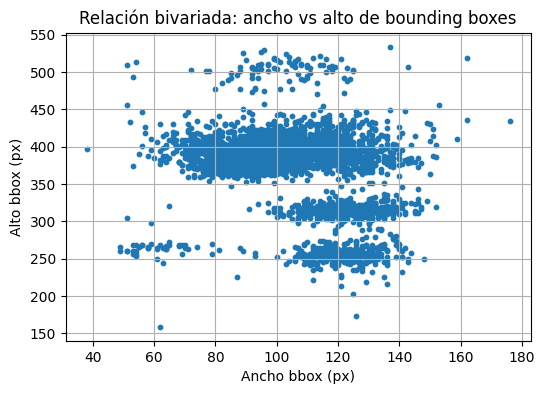

In [46]:
# Análisis bivariado/multivariado con bounding boxes (bndbox)
# Se analiza distribución de tamaños de cajas: ancho, alto, área y relación de aspecto.

import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os

bbox_w, bbox_h, bbox_area, bbox_ar = [], [], [], []

for base in valid_bases:
    xml_path = os.path.join(data_dir, base + ".xml")
    root = ET.parse(xml_path).getroot()
    for obj in root.findall("object"):
        bnd = obj.find("bndbox")
        xmin = int(float(bnd.find("xmin").text))
        ymin = int(float(bnd.find("ymin").text))
        xmax = int(float(bnd.find("xmax").text))
        ymax = int(float(bnd.find("ymax").text))

        w = max(1, xmax - xmin)
        h = max(1, ymax - ymin)
        a = w * h
        ar = w / h

        bbox_w.append(w)
        bbox_h.append(h)
        bbox_area.append(a)
        bbox_ar.append(ar)

bbox_w = np.array(bbox_w)
bbox_h = np.array(bbox_h)
bbox_area = np.array(bbox_area)
bbox_ar = np.array(bbox_ar)

print("Total bounding boxes:", len(bbox_area))
print("Área - min/mean/max:", bbox_area.min(), bbox_area.mean(), bbox_area.max())

# Histograma de áreas
plt.figure(figsize=(6,4))
plt.hist(bbox_area, bins=30)
plt.title("Distribución del área de bounding boxes")
plt.xlabel("Área (px^2)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Scatter ancho vs alto
plt.figure(figsize=(6,4))
plt.scatter(bbox_w, bbox_h, s=10)
plt.title("Relación bivariada: ancho vs alto de bounding boxes")
plt.xlabel("Ancho bbox (px)")
plt.ylabel("Alto bbox (px)")
plt.grid(True)
plt.show()


Paso 10 — Análisis de relaciones y conclusiones del EDA

En este paso se evalúan posibles relaciones entre variables del conjunto de datos, tales como la relación entre el número de objetos por imagen y las características del dataset. Asimismo, se presentan las conclusiones generales del análisis exploratorio.

In [47]:
# Correlación entre número de objetos por imagen y dimensiones
# (en este caso, las dimensiones son constantes)

corr = np.corrcoef(object_counts, heights)[0,1]
print("Correlación objetos vs altura:", corr)


Correlación objetos vs altura: nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Evitando el warning

In [48]:
if np.std(heights) == 0:
    print("Las dimensiones son constantes; no se puede calcular correlación.")
else:
    corr = np.corrcoef(object_counts, heights)[0,1]
    print("Correlación objetos vs altura:", corr)


Las dimensiones son constantes; no se puede calcular correlación.


Conclusiones generales del Análisis Exploratorio de Datos (EDA)

A partir del análisis exploratorio realizado sobre el conjunto de datos, se obtuvieron las siguientes conclusiones principales:

El dataset presenta una estructura consistente y bien definida, compuesto por pares imagen–anotación (JPG + XML), sin errores de lectura ni archivos de anotación vacíos.

Se identificaron valores faltantes únicamente en el sentido de imágenes sin archivo XML asociado; dichas muestras fueron excluidas para garantizar la consistencia del análisis.

Todas las imágenes cuentan con una resolución homogénea de 720 × 540 píxeles, lo que elimina la necesidad de aplicar redimensionamiento como parte del preprocesamiento.

No se detectaron valores atípicos en las dimensiones de las imágenes ni en el número de objetos anotados por imagen, el cual se mantiene dentro de un rango acotado.

El análisis de la variable categórica evidenció una cardinalidad moderada (10 clases) y un desequilibrio en la distribución de clases, lo cual deberá considerarse durante la etapa de entrenamiento del modelo.

La evaluación de relaciones entre variables mostró que no existen correlaciones significativas entre el número de objetos por imagen y las dimensiones, debido a la ausencia de variabilidad en estas últimas.

En general, el conjunto de datos es adecuado para el desarrollo del proyecto, proporcionando una base sólida para las siguientes etapas de preprocesamiento, modelado y evaluación.